In [ ]:
# 250325

import json
import pandas as pd
import os

path = r'../0_data/exam_origin.json'
with open(path, 'r') as f:
    data = json.load(f)

def norm_question_number(ques_num, subject_id):
    if   subject_id == '1-1': ques_num -= 0
    elif subject_id == '1-2': ques_num -= 20
    elif subject_id == '1-3': ques_num -= 40
    elif subject_id == '1-4': ques_num -= 60
    elif subject_id == '1-5': ques_num -= 80
    elif subject_id == '2-1': ques_num -= 0
    elif subject_id == '2-2': ques_num -= 18
    elif subject_id == '2-3': ques_num -= 36
    elif subject_id == '2-4': ques_num -= 54
    elif subject_id == '2-5': ques_num -= 72
    elif subject_id == '3-1': ques_num -= 0
    elif subject_id == '3-2': ques_num -= 0
    elif subject_id == '3-3': ques_num -= 27
    elif subject_id == '3-4': ques_num -= 45
    elif subject_id == '4-1': ques_num -= 63
    return ques_num

df_filter = pd.DataFrame()
for i in range(len(data)):
    year = data[i]['year']
    subject_id = data[i]['subject_id']
    question_number = data[i]['question_number']
    question_text = data[i]['question_text']
    
    idx = norm_question_number(question_number, subject_id)
    column_name = f"{year}_{subject_id}"
    if "<자료(비공개)>" in question_text:
        value = 1
    else:
        value = 0
    df_filter.loc[idx, column_name] = value

In [ ]:
import pandas as pd
from glob import glob
import re
import numpy as np

path_tpl = r"../0_data/model_info.csv"
df_tpl = pd.read_csv(path_tpl, index_col=0)
df_list = df_tpl.index.tolist()
score_path = r"../2_analyze/.detailed/score"
lang_list = ["eng", "kor"]
plot_path = ".plot"
os.makedirs(plot_path, exist_ok=True)

def hypen_cut(col_name):
    return col_name.split('_')[-1]
def underscore_cut(col_name):
    return col_name.split('-')[0]

def calc_accuracy(save_path, filter_method):
    for lang in lang_list:
        result = pd.DataFrame()
        for i in df_list:
            files = glob(fr'{score_path}/*{i}*{lang}*')
            df_ck = pd.read_csv(files[0], index_col=0)
            df_ck = filter_method(df_ck)
            sr_ck=df_ck.sum().astype(int)
            sr_ck = sr_ck.to_frame().T
            df_grouped = sr_ck.T.groupby(by=lambda col: hypen_cut(col)).sum().T.astype(int)
            df_grouped_grouped = df_grouped.T.groupby(by=lambda col: underscore_cut(col)).sum().T.astype(int)

            cnt = df_ck.count()
            cnt = cnt.to_frame().T
            cnt_grouped = cnt.T.groupby(by=lambda col: hypen_cut(col)).sum().T.astype(int)
            cnt_grouped_grouped = cnt_grouped.T.groupby(by=lambda col: underscore_cut(col)).sum().T.astype(int)

            df_grouped = df_grouped.div(cnt_grouped)
            df_grouped_grouped = df_grouped_grouped.div(cnt_grouped_grouped)
            df_grouped_grouped

            temp = pd.concat([df_grouped, df_grouped_grouped], axis=1)
            temp.index = [i]
            result = pd.concat([result, temp])
        os.makedirs(save_path, exist_ok=True)
        result.to_csv(f"{save_path}/{lang}.csv")

save_path = ".filtered"
calc_accuracy(f'{save_path}/non', lambda df: df.where(df_filter == 0))
calc_accuracy(f'{save_path}/cen', lambda df: df.where(df_filter != 0))
calc_accuracy(f'{save_path}/tot', lambda df: df)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

ref_path = r'../0_data/reference.csv'
df_ref = pd.read_csv(ref_path, index_col=0).T.drop(columns=['Total'])

def plot_1(df_eng_2, df_ref, mode):
    if mode == 'class':
        groups_mean = df_eng_2.groupby('Class').mean(numeric_only=True)
        groups_std = df_eng_2.groupby('Class').std(numeric_only=True)
        print(groups_mean)
        class_order = ["P", "L", "M", "S"]
    elif mode == 'performance':
        df_high = df_eng_2[df_eng_2['High'] == True]
        df_low = df_eng_2[df_eng_2['Low'] == True]
        df_merg = pd.concat([df_high, df_low], axis=0, keys=['High', 'Low']).drop(columns=['Class'])
        groups_mean = df_merg.groupby(level=0).mean(numeric_only=True)
        groups_std = df_merg.groupby(level=0).std(numeric_only=True)
    groups_mean = groups_mean.reindex(class_order)
    groups_std = groups_std.reindex(class_order)
    ####################################################################
    pattern = re.compile(r"\d+-\d+")
    columns = [col for col in groups_mean.columns if pattern.match(col)]
    groups_mean_ = groups_mean[columns]
    groups_std_ = groups_std[columns]
    groups_mean_ = groups_mean_.dropna(axis=1)
    groups_std_ = groups_std_.dropna(axis=1)
    plt.figure(figsize=(6, 4))
    for i, row in groups_mean_.iterrows():
        plt.plot(row.index, row*100, label=i)
        plt.fill_between(row.index, (row-groups_std_.loc[i])*100, (row+groups_std_.loc[i])*100, alpha=0.2)
    plt.legend()
    plt.xticks(np.arange(0, len(row.index), 1))
    plt.ylim(0, 100)
    plt.xlabel('Topic')
    plt.ylabel('Score')
    plt.xticks(rotation=90)
    plt.grid(axis='x', linestyle='-', alpha=0.3)
    plt.savefig(f'{plot_path}/3-perf_{mode}.pdf', bbox_inches='tight', format='pdf')
    plt.show()
    ####################################################################
    pattern = re.compile(r"\d")
    columns = [col for col in groups_mean.columns if pattern.match(col) and len(col) == 1]
    groups_mean_ = groups_mean[columns]
    groups_std_ = groups_std[columns]
    groups_mean_ = groups_mean_.dropna(axis=1)
    groups_std_ = groups_std_.dropna(axis=1)
    groups_mean_.loc['Reference'] = df_ref.loc['mean']/100
    groups_std_.loc['Reference'] = df_ref.loc['SD']/100

    plt.figure(figsize=(6, 4))
    for i, row in groups_mean_.iterrows():
        if i != 'Reference':
            plt.plot(row.index, row*100, label=i)
            plt.fill_between(row.index, (row-groups_std_.loc[i])*100, (row+groups_std_.loc[i])*100, alpha=0.2)
        else:
            plt.scatter(row.index, row*100, label=i, color='black', marker='x', alpha=0.5, zorder=10)
    plt.legend()
    plt.xticks(np.arange(0, len(row.index), 1))
    plt.ylim(35, 100)
    plt.xlabel('Subject')
    plt.ylabel('Score')
    plt.savefig(f'{plot_path}/3-perf_whole_{mode}.pdf', bbox_inches='tight', format='pdf')
    plt.show()
    ####################################################################
    df_norm = (groups_mean_ - groups_mean_.loc['Reference']) / groups_std_.loc['Reference']
    df_norm = df_norm.drop('Reference')
    df_perc = pd.DataFrame(stats.norm.cdf(df_norm) * 100, index=df_norm.index, columns=df_norm.columns)
    plt.figure(figsize=(6, 4))
    for i, row in df_perc.iterrows():
        plt.plot(row.index, row, label=i)
    plt.legend()
    plt.ylim(0, 100)
    plt.xticks(np.arange(0, len(row.index), 1))
    plt.xlabel('Subject')
    plt.ylabel('Percentile Score')
    plt.grid(axis='x', linestyle='-', alpha=0.3)
    plt.savefig(f'{plot_path}/3-std_whole.pdf', bbox_inches='tight', format='pdf')
    plt.show()

def plot_2(df_eng_2, df_kor_2):
    df_eng_2_mean = df_eng_2.mean(numeric_only=True)
    df_kor_2_mean = df_kor_2.mean(numeric_only=True)
    merged_mean = pd.concat([df_eng_2_mean, df_kor_2_mean], axis=0, keys=['eng', 'kor'])
    merged_mean = merged_mean.unstack()

    df_eng_2_std = df_eng_2.std(numeric_only=True)
    df_kor_2_std = df_kor_2.std(numeric_only=True)
    merged_std = pd.concat([df_eng_2_std, df_kor_2_std], axis=0, keys=['eng', 'kor'])
    merged_std = merged_std.unstack()

    merged_mean = merged_mean.dropna(axis=1)
    merged_std = merged_std.dropna(axis=1)

    class_order = ["P", "L", "M", "S"]
    merged_mean = merged_mean.reindex(class_order)
    merged_std = merged_std.reindex(class_order)
    ####################################################################
    pattern = re.compile(r"\d+-\d+")
    columns = [col for col in merged_mean.columns if pattern.match(col)]
    merged_mean_ = merged_mean[columns]
    merged_std_ = merged_std[columns]
    plt.figure(figsize=(6, 4))
    for i, row in merged_mean_.iterrows():
        plt.plot(row.index, row*100, label=i)
        plt.fill_between(row.index, (row-merged_std_.loc[i])*100, (row+merged_std_.loc[i])*100, alpha=0.2)
    plt.ylim(0, 100)
    plt.legend()
    plt.xticks(np.arange(0, len(row.index), 1))
    plt.xlabel('Subject')
    plt.ylabel('Percentile Score')
    # rotate x labels
    plt.show()
    ####################################################################
    pattern = re.compile(r"\d")
    columns = [col for col in merged_mean.columns if pattern.match(col) and len(col) == 1]
    merged_mean_ = merged_mean[columns]
    merged_std_ = merged_std[columns]
    plt.figure(figsize=(6, 4))
    for i, row in merged_mean_.iterrows():
        plt.plot(row.index, row*100, label=i)
        plt.fill_between(row.index, (row-merged_std_.loc[i])*100, (row+merged_std_.loc[i])*100, alpha=0.2)
    plt.ylim(0, 100)
    plt.legend()
    plt.xticks(np.arange(0, len(row.index), 1))
    plt.xlabel('Subject')
    plt.ylabel('Score')
    plt.show()

def plot_3(df_eng_2, df_kor_2, mode):
    if mode == 'class':
        diff = df_eng_2.select_dtypes(include='number') - df_kor_2.select_dtypes(include='number')
        diff['Class'] = df_eng_2['Class']
        diff_mean = diff.groupby('Class').mean(numeric_only=True).dropna(axis=1)
        diff_std = diff.groupby('Class').std(numeric_only=True).dropna(axis=1)
    elif mode == 'performance':
        diff = df_eng_2.select_dtypes(include='number') - df_kor_2.select_dtypes(include='number')
        diff['High'] = df_eng_2['High']
        diff['Low'] = df_eng_2['Low']
        df_high = diff[diff['High'] == True]
        df_low = diff[diff['Low'] == True]
        df_merg = pd.concat([df_high, df_low], axis=0, keys=['High', 'Low'])
        diff_mean = df_merg.groupby(level=0).mean(numeric_only=True).dropna(axis=1)
        diff_std = df_merg.groupby(level=0).std(numeric_only=True).dropna(axis=1)
    class_order = ["P", "L", "M", "S"]
    diff_mean = diff_mean.reindex(class_order)
    diff_std = diff_std.reindex(class_order)
    ####################################################################
    pattern = re.compile(r"\d+-\d+")
    columns = [col for col in diff_mean.columns if pattern.match(col)]
    diff_mean_ = diff_mean[columns]
    diff_std_ = diff_std[columns]
    plt.figure(figsize=(6, 4))
    for i, row in diff_mean_.iterrows():
        plt.plot(row.index, row*100, label=i)
        plt.fill_between(row.index, (row-diff_std_.loc[i])*100, (row+diff_std_.loc[i])*100, alpha=0.2)
    plt.legend()
    plt.xticks(np.arange(0, len(row.index), 1))
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
    plt.xlabel('Topic')
    plt.ylabel('Score Difference')
    plt.xticks(rotation=90)
    plt.grid(axis='x', linestyle='-', alpha=0.3)
    plt.savefig(f'{plot_path}/3-lang_diff_{mode}.pdf', bbox_inches='tight', format='pdf')
    plt.show()
    ####################################################################
    # pattern = re.compile(r"\d")
    # columns = [col for col in diff_mean.columns if pattern.match(col) and len(col) == 1]
    # diff_mean_ = diff_mean[columns]
    # diff_std_ = diff_std[columns]
    # plt.figure(figsize=(6, 4))
    # for i, row in diff_mean_.iterrows():
    #     plt.plot(row.index, row*100, label=i)
    #     plt.fill_between(row.index, (row-diff_std_.loc[i])*100, (row+diff_std_.loc[i])*100, alpha=0.2)
    # plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    # plt.legend()
    # plt.xlabel('Subject')
    # plt.ylabel('Score Difference')
    # plt.savefig(f'{plot_path}/3-lang_diff_whole_{mode}.pdf', bbox_inches='tight', format='pdf')
    # plt.show()

def batch_plot(acc_path, scr_col, mode):
    eng_path = f"{acc_path}/eng.csv"
    df_eng = pd.read_csv(eng_path, index_col=0)
    df_eng_2 = pd.concat([df_tpl, df_eng], axis=1)
    df_eng_2
    df_eng_2 = df_eng_2[df_eng_2['Scoring2'] == True]
    kor_path = f"{acc_path}/kor.csv"
    df_kor = pd.read_csv(kor_path, index_col=0)
    df_kor_2 = pd.concat([df_tpl, df_kor], axis=1)
    df_kor_2 = df_kor_2[df_kor_2[scr_col] == True]
        
    plot_1(df_eng_2, df_ref, mode)
    # plot_2(df_eng_2, df_kor_2)
    plot_3(df_eng_2, df_kor_2, mode)

          Params  Scoring  Scoring2      Dist   eng-rate   kor-rate  eng-pass  \
Class                                                                           
L      76.833333      1.0       1.0  0.666667  71.753968  65.047619  5.166667   
M      27.500000      1.0       1.0  0.000000  67.952381  53.500000  4.500000   
P            NaN      1.0       1.0  1.000000  75.734694  72.768707  5.714286   
S       8.000000      1.0       1.0  0.000000  62.891156  45.741497  2.571429   

       kor-pass   eng-perc       1-1  ...       2-5       3-1       3-2  \
Class                                 ...                                 
L      4.500000  47.583333  0.848485  ...  0.837963  0.777778  0.691239   
M      1.500000  34.375000  0.856061  ...  0.784722  0.747835  0.665064   
P      4.857143  60.442857  0.887446  ...  0.876984  0.820656  0.770147   
S      0.142857  17.128571  0.821068  ...  0.716931  0.658318  0.577839   

            3-3       3-4       4-1         1         2       

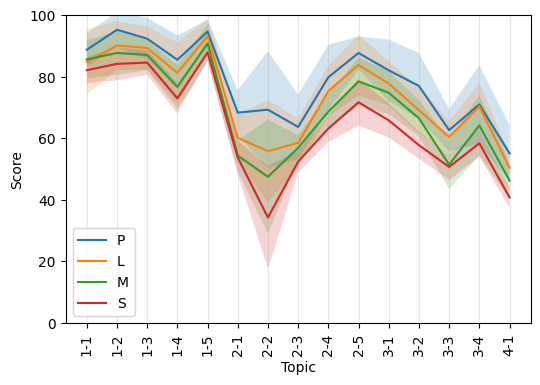

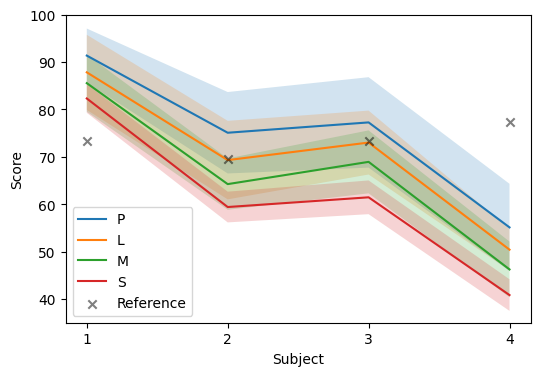

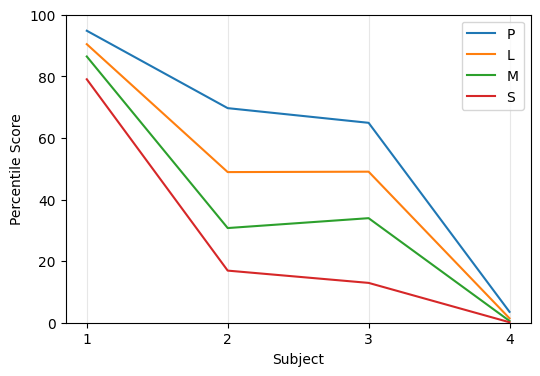

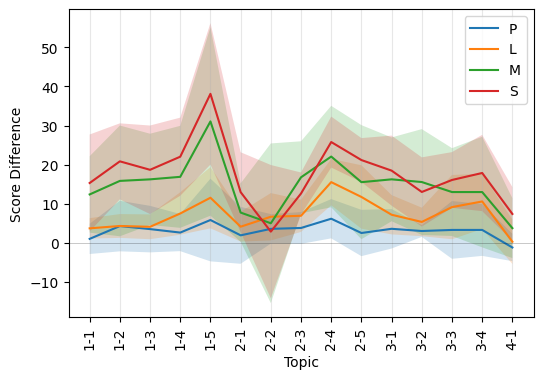

In [4]:
acc_path = r".filtered/non"
# acc_path = r".filtered/cen"
# batch_plot(acc_path, 'Scoring2')
batch_plot(acc_path, 'Scoring2', 'class')
# batch_plot(acc_path, 'Scoring2', 'performance')

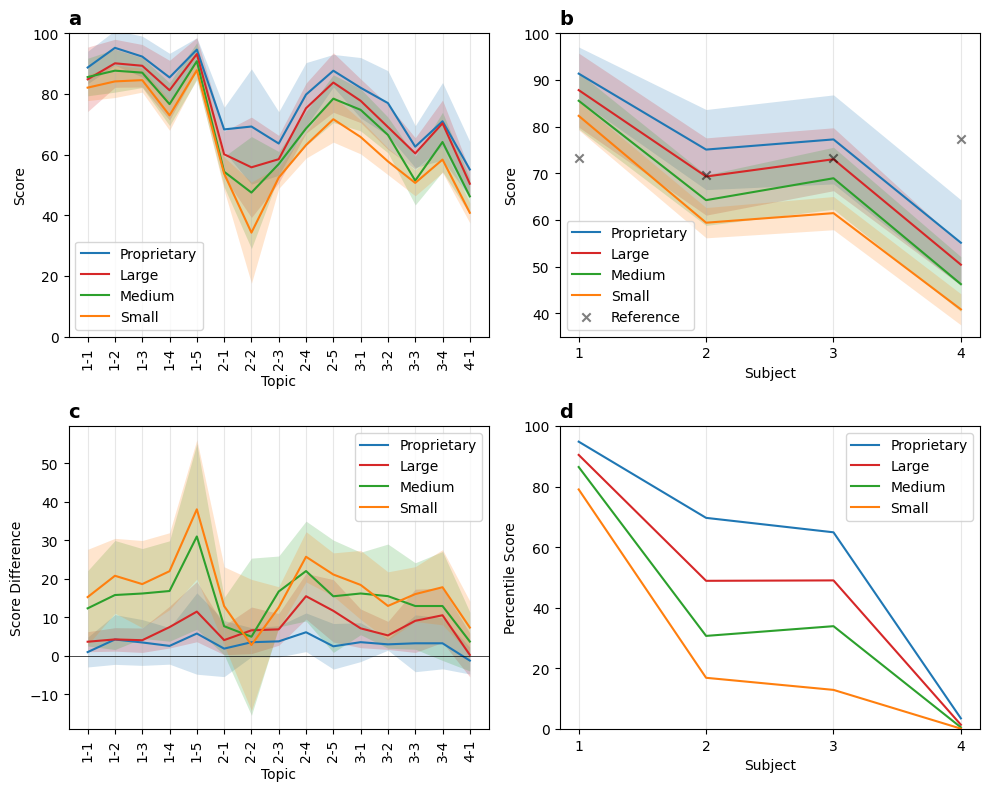

In [ ]:
import json
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

path = r'../0_data/exam_origin.json'
with open(path, 'r') as f:
    data = json.load(f)

def norm_question_number(ques_num, subject_id):
    if   subject_id == '1-1': ques_num -= 0
    elif subject_id == '1-2': ques_num -= 20
    elif subject_id == '1-3': ques_num -= 40
    elif subject_id == '1-4': ques_num -= 60
    elif subject_id == '1-5': ques_num -= 80
    elif subject_id == '2-1': ques_num -= 0
    elif subject_id == '2-2': ques_num -= 18
    elif subject_id == '2-3': ques_num -= 36
    elif subject_id == '2-4': ques_num -= 54
    elif subject_id == '2-5': ques_num -= 72
    elif subject_id == '3-1': ques_num -= 0
    elif subject_id == '3-2': ques_num -= 0
    elif subject_id == '3-3': ques_num -= 27
    elif subject_id == '3-4': ques_num -= 45
    elif subject_id == '4-1': ques_num -= 63
    return ques_num

df_filter = pd.DataFrame()
for i in range(len(data)):
    year = data[i]['year']
    subject_id = data[i]['subject_id']
    question_number = data[i]['question_number']
    question_text = data[i]['question_text']
    
    idx = norm_question_number(question_number, subject_id)
    column_name = f"{year}_{subject_id}"
    if "<자료(비공개)>" in question_text:
        value = 1
    else:
        value = 0
    df_filter.loc[idx, column_name] = value

from glob import glob
path_tpl = r"../0_data/model_info.csv"
df_tpl = pd.read_csv(path_tpl, index_col=0)
df_list = df_tpl.index.tolist()
score_path = r"../2_analyze/.detailed/score"
lang_list = ["eng", "kor"]
plot_path = ".plot"
os.makedirs(plot_path, exist_ok=True)

def hypen_cut(col_name):
    return col_name.split('_')[-1]

def underscore_cut(col_name):
    return col_name.split('-')[0]
def calc_accuracy(save_path, filter_method):
    for lang in lang_list:
        result = pd.DataFrame()
        for i in df_list:
            files = glob(fr'{score_path}/*{i}*{lang}*')
            df_ck = pd.read_csv(files[0], index_col=0)
            df_ck = filter_method(df_ck)
            sr_ck = df_ck.sum().astype(int)
            sr_ck = sr_ck.to_frame().T
            df_grouped = sr_ck.T.groupby(by=lambda col: hypen_cut(col)).sum().T.astype(int)
            df_grouped_grouped = df_grouped.T.groupby(by=lambda col: underscore_cut(col)).sum().T.astype(int)

            cnt = df_ck.count()
            cnt = cnt.to_frame().T
            cnt_grouped = cnt.T.groupby(by=lambda col: hypen_cut(col)).sum().T.astype(int)
            cnt_grouped_grouped = cnt_grouped.T.groupby(by=lambda col: underscore_cut(col)).sum().T.astype(int)

            df_grouped = df_grouped.div(cnt_grouped)
            df_grouped_grouped = df_grouped_grouped.div(cnt_grouped_grouped)
            temp = pd.concat([df_grouped, df_grouped_grouped], axis=1)
            temp.index = [i]
            result = pd.concat([result, temp])
        os.makedirs(save_path, exist_ok=True)
        result.to_csv(f"{save_path}/{lang}.csv")

save_path = ".filtered"
calc_accuracy(f'{save_path}/non', lambda df: df.where(df_filter == 0))
calc_accuracy(f'{save_path}/cen', lambda df: df.where(df_filter != 0))
calc_accuracy(f'{save_path}/tot', lambda df: df)

ref_path = r'../0_data/reference.csv'
df_ref = pd.read_csv(ref_path, index_col=0).T.drop(columns=['Total'])

# ------------------------------------------------------------------
def combined_plots(df_eng_2, df_kor_2, df_ref, mode):
    if mode == 'class':
        groups_mean = df_eng_2.groupby('Class').mean(numeric_only=True)
        groups_std = df_eng_2.groupby('Class').std(numeric_only=True)
        class_order = ["P", "L", "M", "S"]
    elif mode == 'performance':
        df_high = df_eng_2[df_eng_2['High'] == True]
        df_low = df_eng_2[df_eng_2['Low'] == True]
        df_merg = pd.concat([df_high, df_low], axis=0, keys=['High', 'Low']).drop(columns=['Class'])
        groups_mean = df_merg.groupby(level=0).mean(numeric_only=True)
        groups_std = df_merg.groupby(level=0).std(numeric_only=True)
        class_order = ["P", "L", "M", "S"]
    groups_mean = groups_mean.reindex(class_order)
    groups_std = groups_std.reindex(class_order)

    pattern_topic = re.compile(r"\d+-\d+")
    topic_columns = [col for col in groups_mean.columns if pattern_topic.match(col)]
    groups_mean_topic = groups_mean[topic_columns].dropna(axis=1)
    groups_std_topic = groups_std[topic_columns].dropna(axis=1)

    pattern_subject = re.compile(r"\d")
    subject_columns = [col for col in groups_mean.columns if pattern_subject.match(col) and len(col) == 1]
    groups_mean_subject = groups_mean[subject_columns].dropna(axis=1)
    groups_std_subject = groups_std[subject_columns].dropna(axis=1)
    groups_mean_subject.loc['Reference'] = df_ref.loc['mean'] / 100
    groups_std_subject.loc['Reference'] = df_ref.loc['SD'] / 100

    df_norm = (groups_mean_subject.drop('Reference') - groups_mean_subject.loc['Reference']) / groups_std_subject.loc['Reference']
    df_perc = pd.DataFrame(stats.norm.cdf(df_norm) * 100, index=df_norm.index, columns=df_norm.columns)

    if mode == 'class':
        diff = df_eng_2.select_dtypes(include='number') - df_kor_2.select_dtypes(include='number')
        diff['Class'] = df_eng_2['Class']
        diff_mean = diff.groupby('Class').mean(numeric_only=True).dropna(axis=1)
        diff_std = diff.groupby('Class').std(numeric_only=True).dropna(axis=1)
    elif mode == 'performance':
        diff = df_eng_2.select_dtypes(include='number') - df_kor_2.select_dtypes(include='number')
        diff['High'] = df_eng_2['High']
        diff['Low'] = df_eng_2['Low']
        df_high = diff[diff['High'] == True]
        df_low = diff[diff['Low'] == True]
        df_merg = pd.concat([df_high, df_low], axis=0, keys=['High', 'Low'])
        diff_mean = df_merg.groupby(level=0).mean(numeric_only=True).dropna(axis=1)
        diff_std = df_merg.groupby(level=0).std(numeric_only=True).dropna(axis=1)
        class_order = ["P", "L", "M", "S"]
    diff_mean = diff_mean.reindex(class_order)
    diff_std = diff_std.reindex(class_order)
    diff_columns = [col for col in diff_mean.columns if pattern_topic.match(col)]
    diff_mean_topic = diff_mean[diff_columns]
    diff_std_topic = diff_std[diff_columns]

    # 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    label_mapping = {"P": "Proprietary", "L": "Large", "M": "Medium", "S": "Small"}
    color_dict = {'P': 'tab:blue', 'S': 'tab:orange', 'M': 'tab:green', 'L': 'tab:red'}

    # ----- Plot A -----
    ax = axs[0, 0]
    for i, row in groups_mean_topic.iterrows():
        ax.plot(row.index, row * 100, label=label_mapping.get(i, i), color=color_dict.get(i))
        ax.fill_between(row.index, (row - groups_std_topic.loc[i]) * 100, (row + groups_std_topic.loc[i]) * 100, alpha=0.2, color=color_dict.get(i), linewidth=0)
    ax.legend()
    ax.set_xticks(np.arange(0, len(row.index), 1))
    ax.set_ylim(0, 100)
    ax.set_xlabel('Topic')
    ax.set_ylabel('Score')
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    ax.grid(axis='x', linestyle='-', alpha=0.3)
    ax.text(0, 1.08, 'a', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')

    # ----- Plot B -----
    ax = axs[0, 1]
    for i, row in groups_mean_subject.iterrows():
        if i != 'Reference':
            ax.plot(row.index, row * 100, label=label_mapping.get(i, i), color=color_dict.get(i))
            ax.fill_between(row.index, (row - groups_std_subject.loc[i]) * 100, (row + groups_std_subject.loc[i]) * 100, alpha=0.2, color=color_dict.get(i), linewidth=0)
        else:
            ax.scatter(row.index, row * 100, label=i, color='black', marker='x', alpha=0.5, zorder=10)
    ax.legend()
    ax.set_xticks(np.arange(0, len(row.index), 1))
    ax.set_ylim(35, 100)
    ax.set_xlabel('Subject')
    ax.set_ylabel('Score')
    ax.grid(axis='x', linestyle='-', alpha=0.3)
    ax.text(0, 1.08, 'b', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')

    # ----- Plot C -----
    ax = axs[1, 0]
    for i, row in diff_mean_topic.iterrows():
        ax.plot(row.index, row * 100, label=label_mapping.get(i, i), color=color_dict.get(i))
        ax.fill_between(row.index, (row - diff_std_topic.loc[i]) * 100, (row + diff_std_topic.loc[i]) * 100, alpha=0.2, color=color_dict.get(i), linewidth=0)
    ax.legend()
    ax.set_xticks(np.arange(0, len(row.index), 1))
    ax.axhline(y=0, color='black', linestyle='-', alpha=1, linewidth=0.5)
    ax.set_xlabel('Topic')
    ax.set_ylabel('Score Difference')
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    ax.grid(axis='x', linestyle='-', alpha=0.3)
    ax.text(0, 1.08, 'c', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')

    # ----- Plot D -----
    ax = axs[1, 1]
    for i, row in df_perc.iterrows():
        ax.plot(row.index, row, label=label_mapping.get(i, i), color=color_dict.get(i))
    ax.legend()
    ax.set_ylim(0, 100)
    ax.set_xticks(np.arange(0, len(row.index), 1))
    ax.set_xlabel('Subject')
    ax.set_ylabel('Percentile Score')
    ax.grid(axis='x', linestyle='-', alpha=0.3)
    ax.text(0, 1.08, 'd', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')

    plt.tight_layout()
    plt.savefig(f'{plot_path}/3-combined.pdf', bbox_inches='tight', format='pdf')
    plt.show()

# ------------------------------------------------------------------

acc_path = r"../2_analyze/.filtered/non"
eng_path = f"{acc_path}/eng.csv"
df_eng = pd.read_csv(eng_path, index_col=0)
df_eng_2 = pd.concat([df_tpl, df_eng], axis=1)
df_eng_2 = df_eng_2[df_eng_2['Scoring2'] == True]

kor_path = f"{acc_path}/kor.csv"
df_kor = pd.read_csv(kor_path, index_col=0)
df_kor_2 = pd.concat([df_tpl, df_kor], axis=1)
df_kor_2 = df_kor_2[df_kor_2['Scoring2'] == True]

combined_plots(df_eng_2, df_kor_2, df_ref, mode='class')